In [194]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d

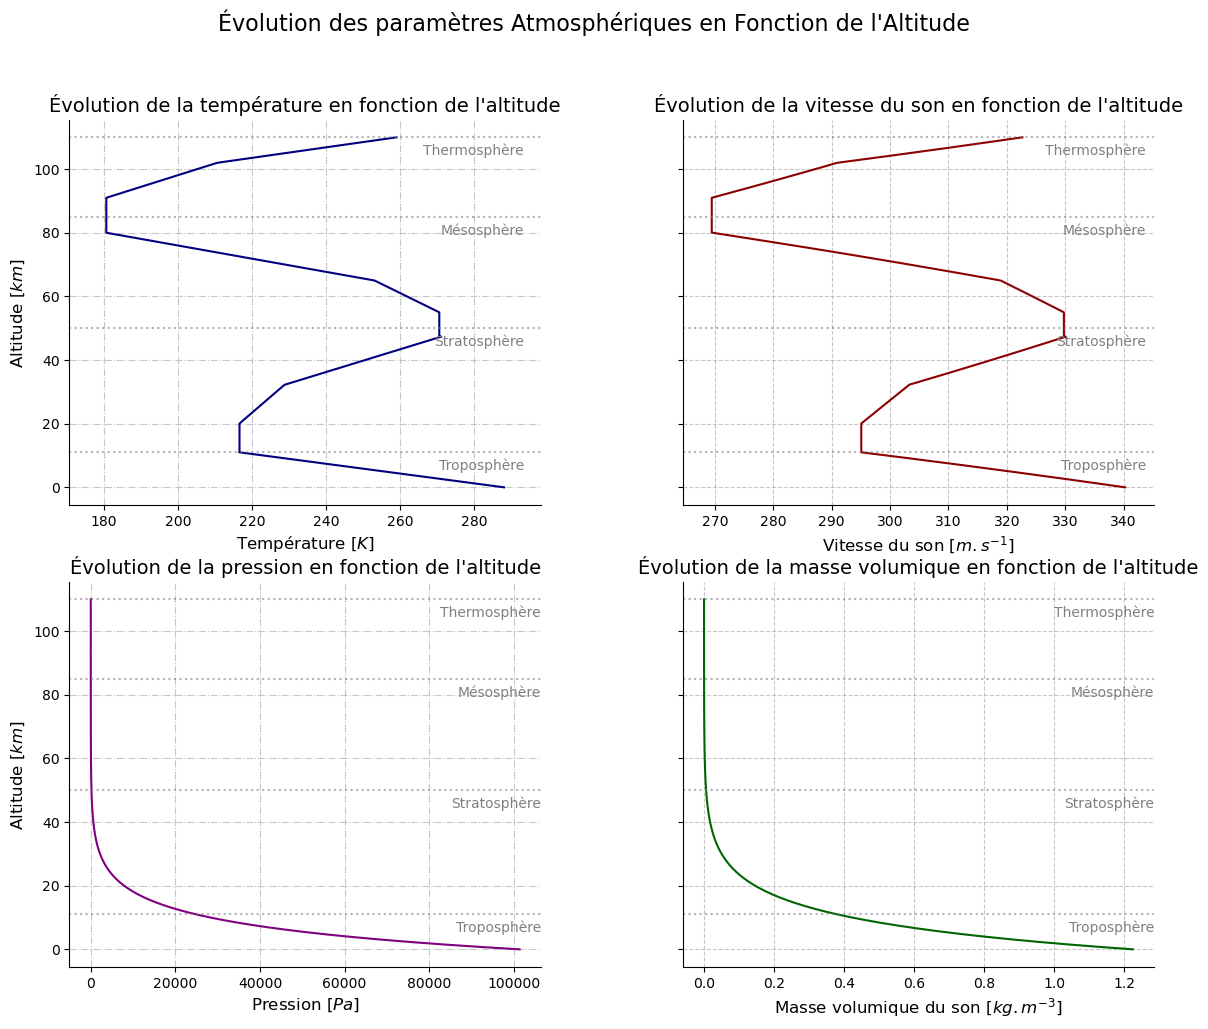

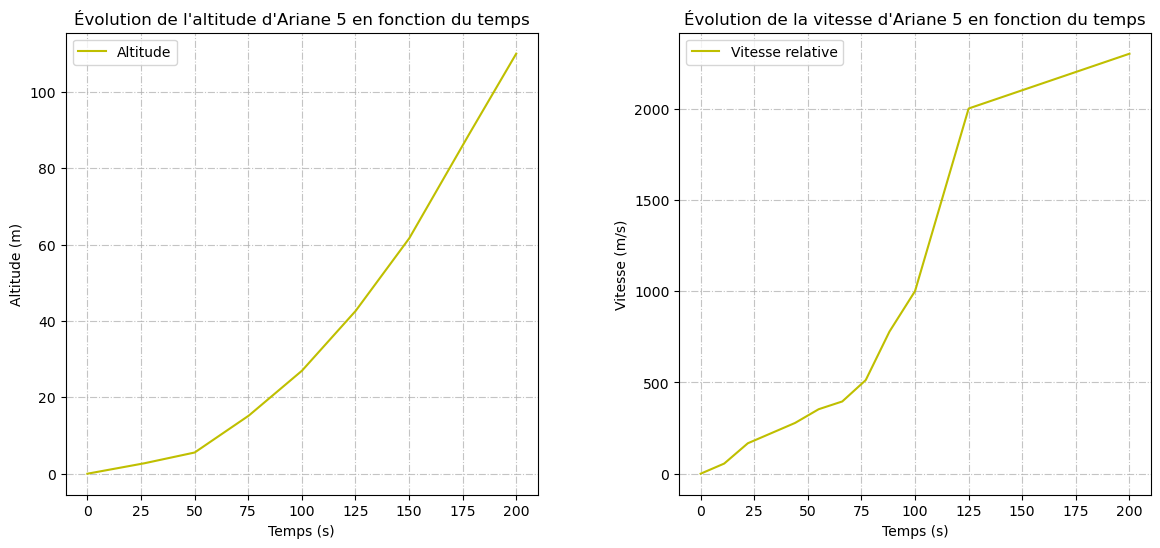

In [195]:
from thermo_property.thermo_properties import Get_ThermoProperties
from thermo_property.thermo_properties import Get_RelativeSpeed

ThermoProperties_dict = Get_ThermoProperties()
PosRel = Get_RelativeSpeed()

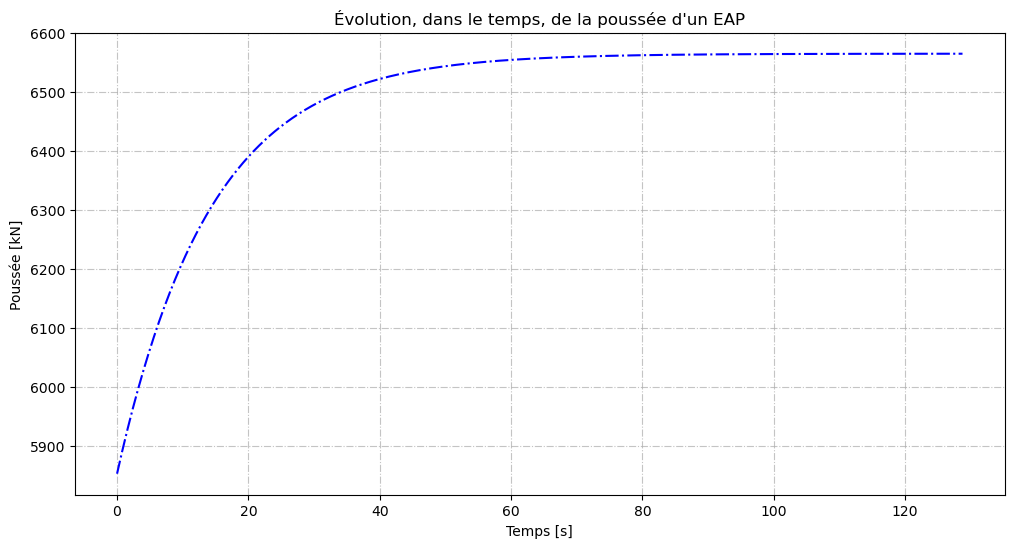

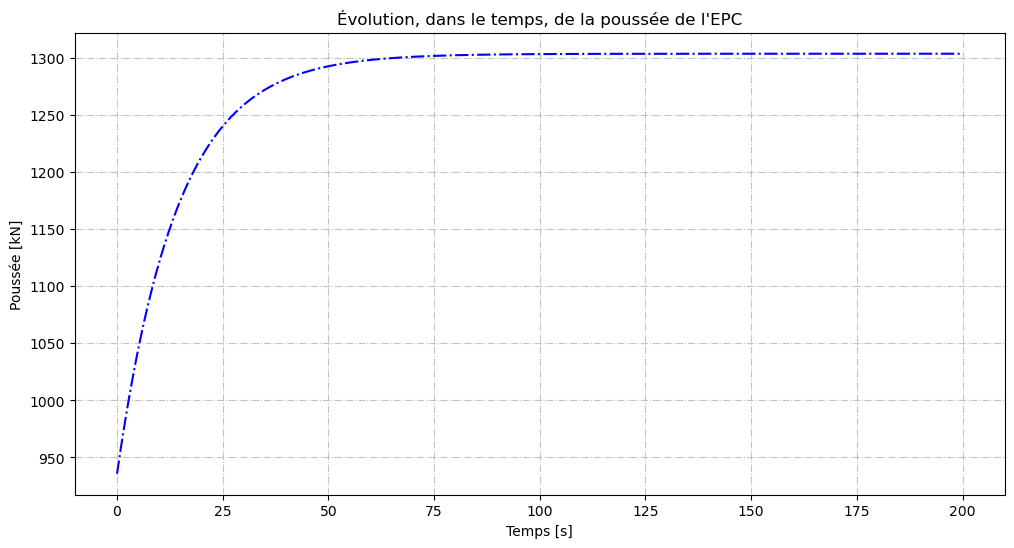

In [196]:
P_inf = ThermoProperties_dict["PRESSION"]
t_sim = np.linspace(0, 200, 1000)
idx_t_129 = np.argmin(np.abs(t_sim - 129))
# ===== POUR UN EAP ===== #

mol_arr = np.array([18, 44, 28, 28, 2])
percent_arr = np.array([0.34, 0.21, 0.12, 0.3, 0.03])
M_mol_comb_EAP = 1e-3/np.sum(percent_arr/mol_arr)

combustion_EAP = {
    "PRESSION": 61.34*1e5,
    "TEMPERATURE": 3000,
    'MASSE MOL': M_mol_comb_EAP,
    'GAMMA': 1.33
}

graph_config_EAP = {
    "PRESSION": P_inf[:idx_t_129],
    "TEMPS": t_sim[:idx_t_129],
    "TITRE": "Évolution, dans le temps, de la poussée d'un EAP",
}

m_prop_EAP = 237.7
t_fnc_EAP = 129
m_dot_EAP = (m_prop_EAP/t_fnc_EAP)*1e3

def Thrust(combustion, m_dot, d_s, graph_config):

    P_c = combustion["PRESSION"]
    T_c = combustion["TEMPERATURE"]
    M_mol = combustion["MASSE MOL"]
    gamma = combustion["GAMMA"]

    R = 8.314
    Cp = gamma * (R/M_mol) / (gamma - 1)
    rho_c = P_c / ((R/M_mol) * T_c)

    # --> col de la tuyère
    coeff = 2 / (gamma + 1)
    T_col = T_c * coeff 
    P_col = P_c * coeff**(gamma / (gamma - 1))
    rho_col = rho_c * coeff**(1 / (gamma - 1))
    v_col = np.sqrt(gamma * (R/M_mol) * T_col)
    A_col = m_dot / (rho_col * v_col)

    # --> divergent tuyère
    A_s = 0.25 * np.pi * d_s**2
    T_s = T_c * (A_col/A_s)**(2*(gamma - 1)/(gamma + 1))
    v_s = np.sqrt(2 * Cp * (T_c - T_s))
    M_s = v_s / np.sqrt(gamma * (R/M_mol) * T_s)
    P_s = P_c / (1 + 0.5 * (gamma - 1) * M_s**2)**(gamma / (gamma -1))
    rho_s = P_s / ((R/M_mol) * T_s)

    ev_Press = graph_config["PRESSION"]
    ev_time = graph_config["TEMPS"]
    title_str = graph_config["TITRE"]

    F_prop = (m_dot * v_s + (P_s - ev_Press) * A_s) *1e-3

    fig, axs = plt.subplots(1, 1, figsize=(12, 6))
    axs.plot(ev_time, F_prop, 'b-.')
    axs.set_ylabel("Poussée [kN]")
    axs.set_xlabel("Temps [s]")
    axs.grid('on', alpha=0.75, linestyle='-.')
    axs.set_title(title_str)

    plt.show()

    end_properties = {
        "PRESSION": P_s,
        "TEMPERATURE": T_s,
        "MASSE VOLUMIQUE": rho_s,
        "VITESSE": v_s,
        "MACH": M_s,
        "POUSSÉE": F_prop
    }

    return end_properties

EAP_properties = Thrust(combustion=combustion_EAP, m_dot=m_dot_EAP, d_s=2.99, graph_config=graph_config_EAP)

# ===== POUR L'EPC ===== #

M_mol_comb_EPC = 18*1e-3

m_prop_EPC = 170.240
t_fnc_EPC = 532
m_dot_EPC = (m_prop_EPC/t_fnc_EPC)*1e3

combustion_EPC = {
    "PRESSION": 117*1e5,
    "TEMPERATURE": 3300,
    'MASSE MOL': M_mol_comb_EPC,
    'GAMMA': 1.29
}

graph_config_EPC = {
    "PRESSION": P_inf,
    "TEMPS": t_sim,
    "TITRE": "Évolution, dans le temps, de la poussée de l'EPC",
}

EPC_properties = Thrust(combustion=combustion_EPC, m_dot=m_dot_EPC, d_s=2.15, graph_config=graph_config_EPC)

Text(0.5, 1.0, "Évolution, dans le temps, de la masse d'Ariane V")

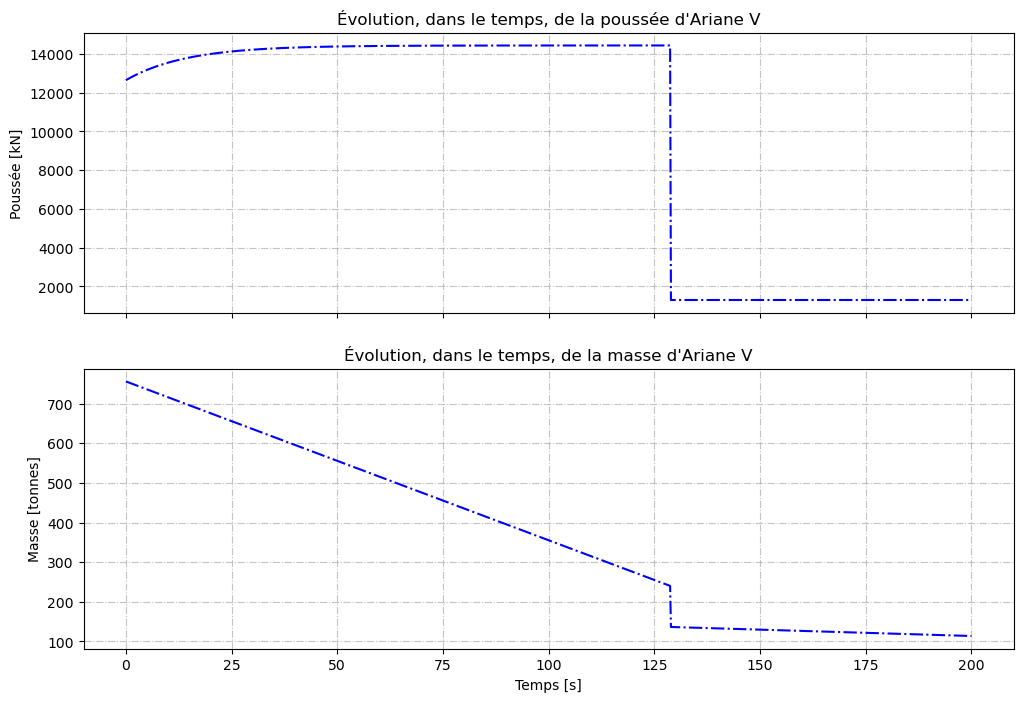

In [197]:
M_tot = 755.8
dt = 0.5
m_dot_EAP = 237.7/129
m_dot_EPC = 170.240/532
m_EAP = 31.2

M_phase_1 = M_tot - (2*m_dot_EAP + m_dot_EPC) * t_sim[:idx_t_129]
M_phase_2 = M_phase_1[-1] - (2*m_EAP) - m_dot_EPC * t_sim[idx_t_129:]
M_vol = np.concatenate([M_phase_1, M_phase_2])

F_EAP = EAP_properties["POUSSÉE"]
F_EAP_1000 = np.pad(F_EAP, (0, 1000 - len(F_EAP)), 'constant', constant_values=0)
F_EPC = EPC_properties["POUSSÉE"]
F_tot = 2 * F_EAP_1000 + F_EPC

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(t_sim, F_tot, 'b-.')
axs[0].set_ylabel("Poussée [kN]")
axs[0].grid('on', alpha=0.75, linestyle='-.')
axs[0].set_title("Évolution, dans le temps, de la poussée d'Ariane V")

axs[1].plot(t_sim, M_vol, 'b-.')
axs[1].set_ylabel("Masse [tonnes]")
axs[1].set_xlabel("Temps [s]")
axs[1].grid('on', alpha=0.75, linestyle='-.')
axs[1].set_title("Évolution, dans le temps, de la masse d'Ariane V")

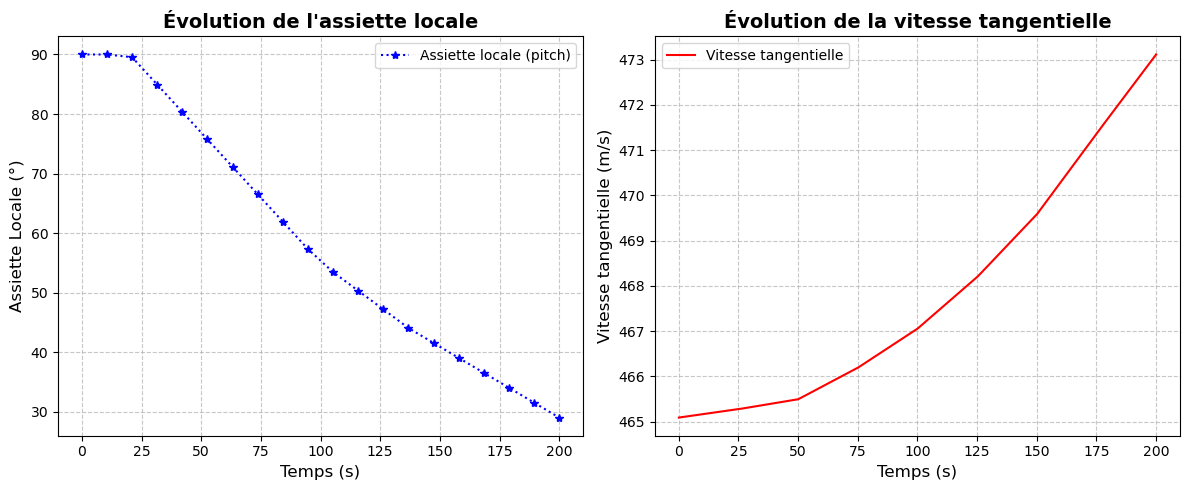

In [198]:
import matplotlib.pyplot as plt
import numpy as np

# Définition des données pour le pitch
local_pitch_updated = [
    (0, 90), (20, 90), (100, 55), (100, 55), (137, 44), (137, 44), (200, 29)
]

time_values_updated = [point[0] for point in local_pitch_updated]
pitch_values_updated = [point[1] for point in local_pitch_updated]

time_interpolated_sample = np.linspace(min(time_values_updated), max(time_values_updated), 20)
pitch_interpolated_sample = np.interp(time_interpolated_sample, time_values_updated, pitch_values_updated)

time = np.linspace(min(time_values_updated), max(time_values_updated), 1000)
pitch = np.interp(time, time_values_updated, pitch_values_updated)

# Définition des données pour la vitesse tangentielle
omega_t = (2 * np.pi) / 86164 
R_t = 6378  

altitude = np.linspace(0, 110, 1000)  

vel_tan = omega_t * (R_t + PosRel['ALTITUDE']) * 1e3

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=False)

axs[0].plot(time_interpolated_sample, pitch_interpolated_sample, 'b:*', linewidth=1.5, label="Assiette locale (pitch)")
axs[0].set_xlabel("Temps (s)", fontsize=12)
axs[0].set_ylabel("Assiette Locale (°)", fontsize=12)
axs[0].set_title("Évolution de l'assiette locale", fontsize=14, fontweight='bold')
axs[0].grid(True, linestyle="--", alpha=0.7)
axs[0].legend()

axs[1].plot(t_sim, vel_tan, 'r-', linewidth=1.5, label="Vitesse tangentielle")
axs[1].set_xlabel("Temps (s)", fontsize=12)
axs[1].set_ylabel("Vitesse tangentielle (m/s)", fontsize=12)
axs[1].set_title("Évolution de la vitesse tangentielle", fontsize=14, fontweight='bold')
axs[1].grid(True, linestyle="--", alpha=0.7)
axs[1].legend()

plt.tight_layout()
plt.show()


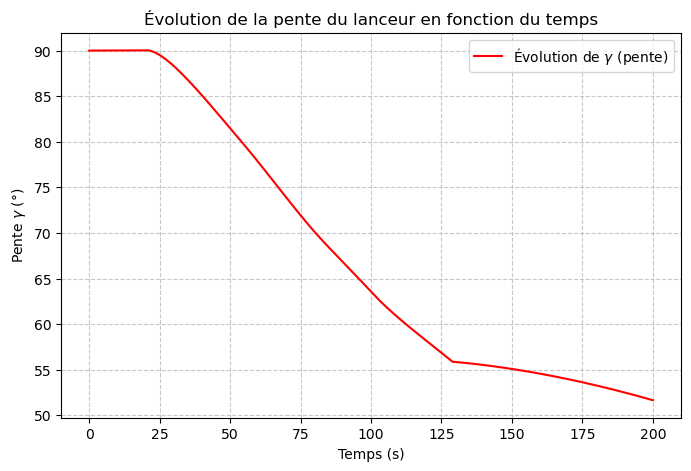

In [199]:
dt = t_sim[1] - t_sim[0] 
gamma_arr = np.zeros_like(t_sim) 
dgamma_arr = np.zeros_like(t_sim)
gamma_arr[0] = 90

VelRel = PosRel["VITESSE"]
VelRel[0] = 1e-1

alti_arr = np.linspace(0, 110, 1000)
G_arr = 398603 / (6378 + alti_arr)**2

for i in range(len(t_sim) - 1):
    dGammadt_i = (1 / VelRel[i]) * (((1e3 * F_tot[i]) / (1e3 * M_vol[i])) * np.sin(np.deg2rad(pitch[i]) - np.deg2rad(gamma_arr[i])) 
                                    - G_arr[i] * np.cos(np.deg2rad(gamma_arr[i]))) + 2 * omega_t + omega_t * (
                                    (vel_tan[i] / VelRel[i]) + (VelRel[i] / vel_tan[i])) * np.cos(np.deg2rad(gamma_arr[i]))
    
    dgamma_arr[i] = dGammadt_i
    # dGammadt_i *= 1.5
    
    if np.isfinite(dGammadt_i):
        gamma_arr[i+1] = gamma_arr[i] + dt * np.rad2deg(dGammadt_i)
    else:
        gamma_arr[i+1] = gamma_arr[i]

plt.figure(figsize=(8, 5))
plt.plot(t_sim, gamma_arr, 'r-', linewidth=1.5, label=r"Évolution de $\gamma$ (pente)")
plt.xlabel("Temps (s)")
plt.ylabel(r"Pente $\gamma$ (°)")
plt.title("Évolution de la pente du lanceur en fonction du temps")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# fig, axs = plt.subplots()


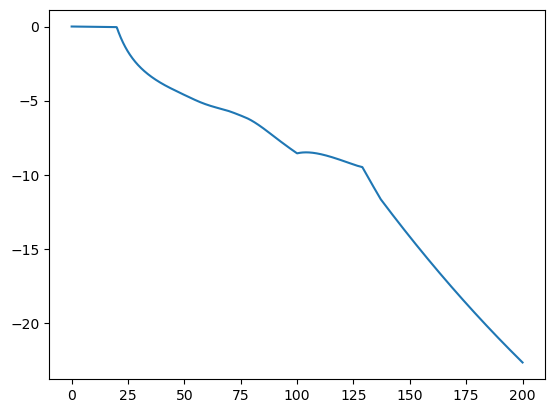

In [202]:
alpha = pitch - gamma_arr

plt.plot(t_sim, alpha)

Text(0.5, 1.0, "Évolution, dans le temps, de la masse d'Ariane V")

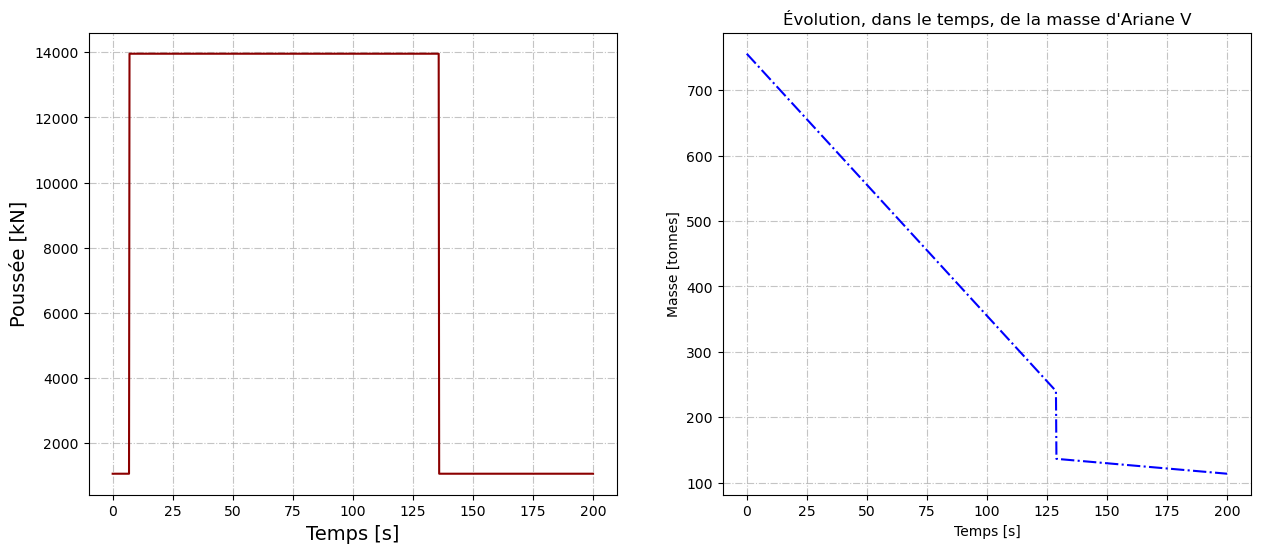

In [200]:
t_sim = np.linspace(0, 200, 1000)

idx_7 = np.argmin(np.abs(t_sim - 7))
idx_136 = np.argmin(np.abs(t_sim - 136))

# vecteur poussée moyenne 
F_EAP = np.zeros(shape=len(t_sim))
F_EAP[idx_7:idx_136] = 12887
F_EPC = np.full(shape=len(t_sim), fill_value=1068)

F_tot_mean = F_EPC + F_EAP

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(t_sim, F_tot_mean, 'darkred')
axs[0].set_xlabel('Temps [s]', fontsize=14)
axs[0].set_ylabel('Poussée [kN]', fontsize=14)
axs[0].grid('on', alpha=0.75, linestyle='-.')

axs[1].plot(t_sim, M_vol, 'b-.')
axs[1].set_ylabel("Masse [tonnes]")
axs[1].set_xlabel("Temps [s]")
axs[1].grid('on', alpha=0.75, linestyle='-.')
axs[1].set_title("Évolution, dans le temps, de la masse d'Ariane V")

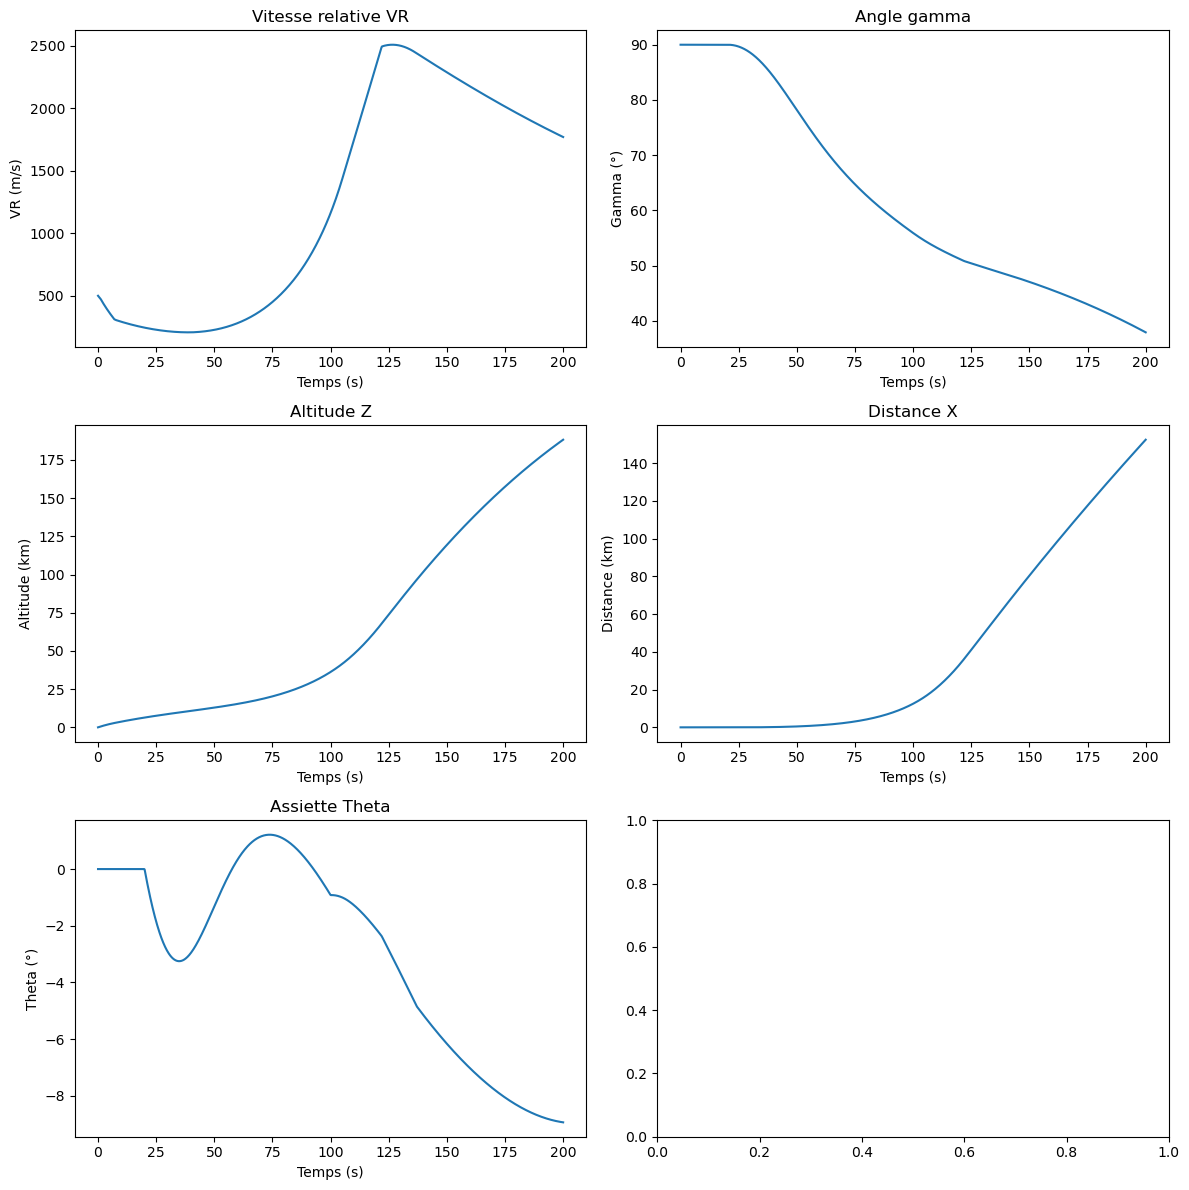

In [224]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constantes
g0 = 9.81  # Accélération gravitationnelle (m/s²)
R_T = 6378000  # Rayon de la Terre (m)
wT = 2 * np.pi / 86164  # Vitesse angulaire de rotation de la Terre (rad/s)
G = 39.86e13  # Constante gravitationnelle terrestre

# Fonction de la masse
def masse(t):
    if t < 7:
        return 780000  # Masse au sol avec ergols
    elif t < 105:
        return 780000 - (2600 + 3869.4) * (t - 7)
    elif t < 122:
        return 780000 - (2600 + 3869.4) * (105 - 7)
    elif t < 137:
        return 780000 - (2600 * (105 - 7)) - 3869.4 * ((t - 105) - ((t - 105) ** 2) / 15)
    else:
        return 780000 - (2600 * (105 - 7)) - 3869.4 * 15 / 2

# Fonction de poussée
def poussee(t):
    if t < 7:
        return 0
    elif t < 122:
        return 1145000 + 2 * 5100000
    elif t < 137:
        return 1145000 - 2 * 5100000 * (t - 137) / 15
    elif t < 589:
        return 1145000
    else:
        return 0

# Fonction de traînée
def trainee(VR, Z):
    rho = 1.225 * np.exp(-0.1064 * (Z / 1000)) if Z < 11000 else 0  # Densité atmosphérique simplifiée
    S = 37 if Z < 13000 else 22.9  # Surface de référence
    CX = 0.4 if VR > 1.4 * 340 else 2.16 if VR > 0.9 * 340 else 0.6
    return 0.5 * rho * S * CX * VR**2

# Fonction de l'assiette theta
def theta(t):
    if t < 20:
        return np.radians(90)
    elif t < 100:
        return np.radians(90 - (t - 20) * (90 - 55) / (100 - 20))
    elif t < 137:
        return np.radians(55 - (t - 100) * (55 - 44) / (137 - 100))
    elif t < 200:
        return np.radians(44 - (t - 137) * (44 - 29) / (200 - 137))
    elif t < 550:
        return np.radians(29 - (t - 200) * (29 - 15) / (550 - 200))
    elif t < 950:
        return np.radians(10 - (t - 550) * (10 - 8) / (950 - 550))
    elif t < 1299:
        return np.radians(8 + (t - 950) * (21 - 8) / (1299 - 950))
    else:
        return np.radians(21)

# Équations différentielles
def equations(t, u):
    VR, gamma, Z, X = u
    M = masse(t)
    F = poussee(t)
    Theta = theta(t)
    G_eff = G / (R_T + max(Z, 0))**2  # Empêcher une altitude négative
    VT = wT * (R_T + max(Z, 0))
    RX = trainee(VR, Z)
    omega_t = (2 * np.pi) / 86164
    
    dVR = F / M - G_eff * np.sin(gamma) - (RX / M) - (G_eff - omega_t * VT) * np.sin(gamma)
    dgamma = (1 / max(VR, 1)) * ((F / M) * np.sin(Theta - gamma) - G_eff * np.cos(gamma)) + 2 * omega_t + omega_t * (VT / VR + VR / VT) * np.cos(gamma) if t > 20 else 0
    dZ = max(VR * np.sin(gamma), 0)  # Empêcher Z de diminuer de manière irréaliste
    dX = (VR * np.cos(gamma)) * R_T / (R_T + max(Z, 0))
    
    return [dVR, dgamma, dZ, dX]

u0 = [500, np.radians(90), 0, 0]
t_span = (0, 200)
t_eval = np.linspace(0, 200, 1000)  

# Résolution du système
tol = 1e-6
sol = solve_ivp(equations, t_span, u0, t_eval=t_eval, method='RK45', rtol=tol, atol=tol)

VR_sol, gamma_sol, Z_sol, X_sol = sol.y
theta_sol = np.array([theta(t) for t in sol.t])

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs[0, 0].plot(sol.t, VR_sol)
axs[0, 0].set_title("Vitesse relative VR")
axs[0, 0].set_xlabel("Temps (s)")
axs[0, 0].set_ylabel("VR (m/s)")

axs[0, 1].plot(sol.t, np.degrees(gamma_sol))
axs[0, 1].set_title("Angle gamma")
axs[0, 1].set_xlabel("Temps (s)")
axs[0, 1].set_ylabel("Gamma (°)")

axs[1, 0].plot(sol.t, Z_sol / 1000)
axs[1, 0].set_title("Altitude Z")
axs[1, 0].set_xlabel("Temps (s)")
axs[1, 0].set_ylabel("Altitude (km)")

axs[1, 1].plot(sol.t, X_sol / 1000)
axs[1, 1].set_title("Distance X")
axs[1, 1].set_xlabel("Temps (s)")
axs[1, 1].set_ylabel("Distance (km)")

axs[2, 0].plot(sol.t, np.degrees(theta_sol - gamma_sol))
axs[2, 0].set_title("Assiette Theta")
axs[2, 0].set_xlabel("Temps (s)")
axs[2, 0].set_ylabel("Theta (°)")

plt.tight_layout()
plt.show()


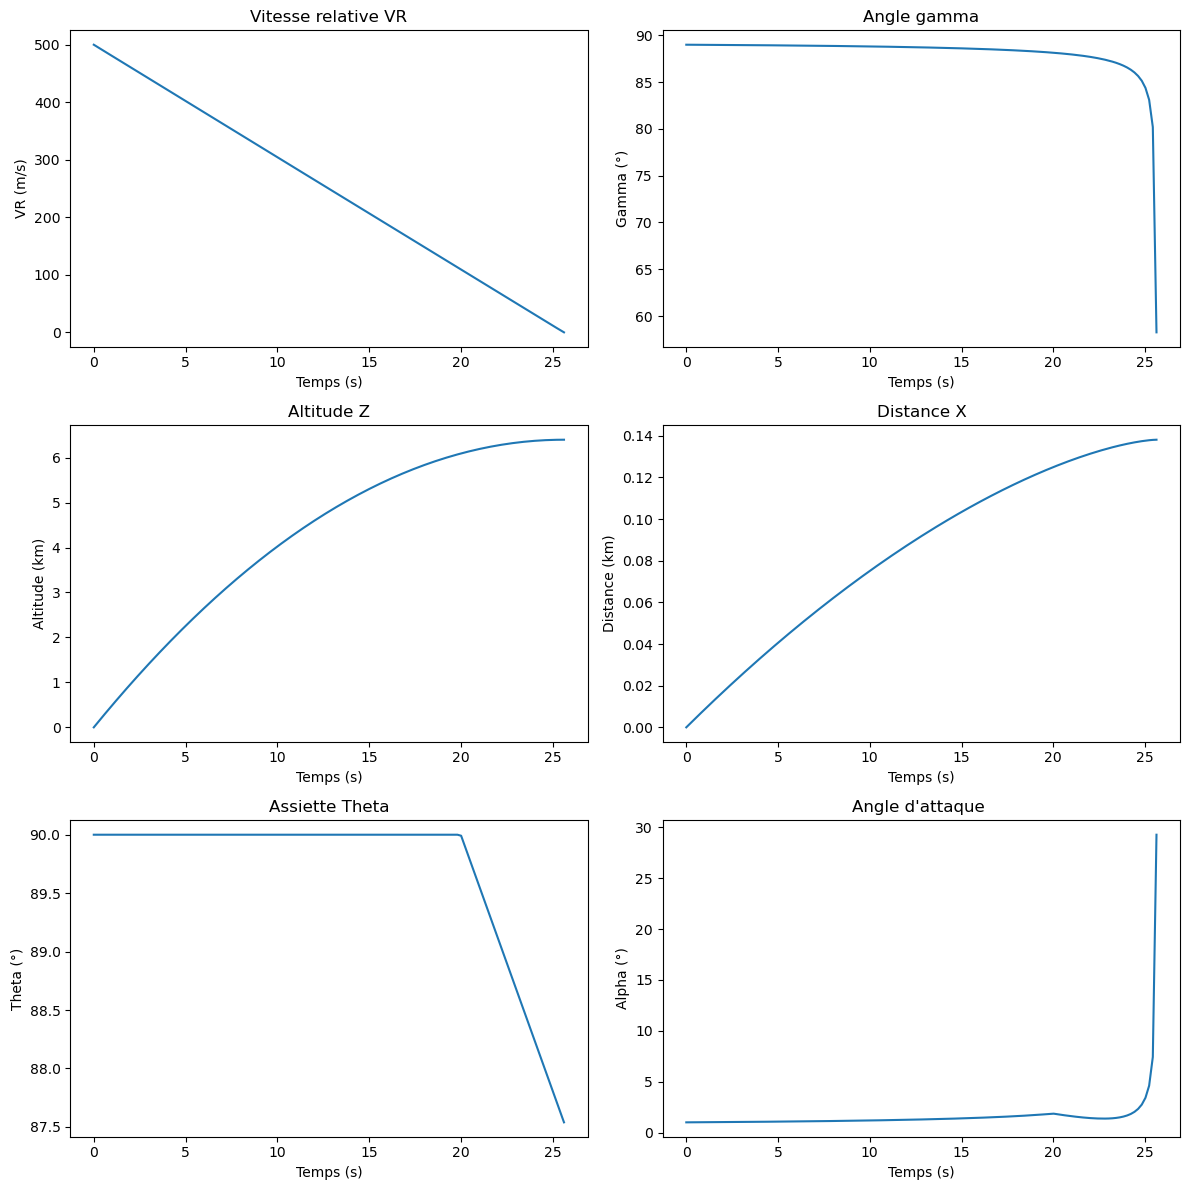

In [275]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constantes
g0 = 9.80665  # Accélération gravitationnelle (m/s²)
R_T = 6378000  # Rayon de la Terre (m)
wT = 2 * np.pi / 86164  # Vitesse angulaire de rotation de la Terre (rad/s)
G = 39.86e13  # Constante gravitationnelle terrestre

# Modélisation de la densité atmosphérique
density_layer = [
    (0, 1.225, -0.1064), 
    (11000, 2.2, -0.15983),
    (34000, 1.05, -0.13807),
    (50000, 0, 0)
]

def density(Z, layers):
    for i in range(len(layers) - 1):
        Z_start, rho_start, rho_z = layers[i]
        Z_next = layers[i + 1][0]

        if Z_start <= Z < Z_next:
            return rho_start * np.exp(rho_z * (Z - Z_start))

    return 0 

# Constantes
g0 = 9.81  # Accélération gravitationnelle (m/s²)
R_T = 6378000  # Rayon de la Terre (m)
wT = 2 * np.pi / 86164  # Vitesse angulaire de rotation de la Terre (rad/s)
G = 39.86e13  # Constante gravitationnelle terrestre
M_tot = 755.8 * 1e3
m_dot_EPC = (170.240 / 532) * 1e3
m_dot_EAP = (237.7 / 129) * 1e3

def masse(t):
    if t < 7:
        return M_tot - m_dot_EPC * t
    elif 7 < t < 137:
        return M_tot - m_dot_EPC * t - 2 * m_dot_EAP * (t - 7)
    else:
        return M_tot - 2 * (268.9 * 1e3) - m_dot_EPC * t


# Fonction de poussée
def poussee(t):
    if t < 7:
        return 1068
    elif 7 < t < 137:
        return 1068 + 12887
    else:
        return 1068

# Fonction de traînée
def trainee(VR, Z):
    rho = density(Z, density_layer)
    S = 37 if Z < 13000 else 22.9  # Surface de référence
    CX = 0.4 if VR > 1.4 * 340 else 2.16 if VR > 0.9 * 340 else 0.6
    return 0.5 * rho * S * CX * VR**2

# Fonction de l'assiette theta
def theta(t):
    if t < 20:
        return np.radians(90)
    elif t < 100:
        return np.radians(90 - (t - 20) * (90 - 55) / (100 - 20))
    elif t < 137:
        return np.radians(55 - (t - 100) * (55 - 44) / (137 - 100))
    else:
        return np.radians(44 - (t - 137) * (44 - 29) / (200 - 137))

# Équations différentielles
def equations(t, u):
    VR, gamma, Z, X = u
    M = masse(t)
    F = poussee(t)
    Theta = theta(t)
    G_eff = G / (R_T + max(Z, 0))**2  # Empêcher une altitude négative
    VT = wT * (R_T + max(Z, 0))
    RX = trainee(VR, Z)
    omega_t = (2 * np.pi) / 86164
    
    dVR = F / M - G_eff * np.cos(Theta - gamma) - (RX / M) - (G_eff - omega_t * VT) * np.sin(gamma)
    dgamma = (1 / max(VR, 1)) * ((F / M) * np.sin(Theta - gamma) - G_eff * np.cos(gamma)) + 2 * omega_t + omega_t * (VT / VR + VR / VT) * np.cos(gamma) #if t > 20 else 0
    dZ = max(VR * np.sin(gamma), 0)
    dX = (VR * np.cos(gamma)) * R_T / (R_T + max(Z, 0))
    
    return [dVR, dgamma, dZ, dX]

# Conditions initiales
u0 = [500, np.radians(89), 0, 0]  # Vitesse initiale plus réaliste, angle de montée progressif
t_span = (0, 200)  # Intervalle de simulation
t_eval = np.linspace(0, 200, 1000)  # Points de temps d'évaluation

# Résolution du système
tol = 1e-6
sol = solve_ivp(equations, t_span, u0, t_eval=t_eval, method='RK45', rtol=tol, atol=tol)

# Extraction des résultats
VR_sol, gamma_sol, Z_sol, X_sol = sol.y
theta_sol = np.array([theta(t) for t in sol.t])

# Tracé des résultats
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs[0, 0].plot(sol.t, VR_sol)
axs[0, 0].set_title("Vitesse relative VR")
axs[0, 0].set_xlabel("Temps (s)")
axs[0, 0].set_ylabel("VR (m/s)")

axs[0, 1].plot(sol.t, np.degrees(gamma_sol))
axs[0, 1].set_title("Angle gamma")
axs[0, 1].set_xlabel("Temps (s)")
axs[0, 1].set_ylabel("Gamma (°)")

axs[1, 0].plot(sol.t, Z_sol / 1000)
axs[1, 0].set_title("Altitude Z")
axs[1, 0].set_xlabel("Temps (s)")
axs[1, 0].set_ylabel("Altitude (km)")

axs[1, 1].plot(sol.t, X_sol / 1000)
axs[1, 1].set_title("Distance X")
axs[1, 1].set_xlabel("Temps (s)")
axs[1, 1].set_ylabel("Distance (km)")

axs[2, 0].plot(sol.t, np.degrees(theta_sol))
axs[2, 0].set_title("Assiette Theta")
axs[2, 0].set_xlabel("Temps (s)")
axs[2, 0].set_ylabel("Theta (°)")

axs[2, 1].plot(sol.t, np.degrees(theta_sol - gamma_sol))
axs[2, 1].set_title("Angle d'attaque ")
axs[2, 1].set_xlabel("Temps (s)")
axs[2, 1].set_ylabel("Alpha (°)")

plt.tight_layout()
plt.show()

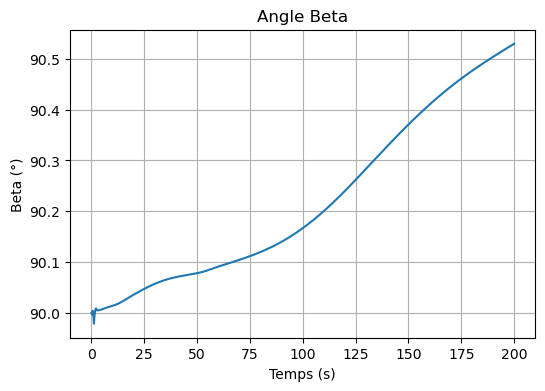

In [273]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constantes
g0 = 9.81  # Accélération gravitationnelle (m/s²)
R_T = 6378000  # Rayon de la Terre (m)
wT = 2 * np.pi / 86164  # Vitesse angulaire de rotation de la Terre (rad/s)
G = 39.86e13  # Constante gravitationnelle terrestre
M_tot = 755.8 * 1e3
m_dot_EPC = (170.240 / 532) * 1e3
m_dot_EAP = (237.7 / 129) * 1e3

def masse(t):
    if t < 7:
        return M_tot - m_dot_EPC * t
    elif 7 < t < 137:
        return M_tot - m_dot_EPC * t - 2 * m_dot_EAP * (t - 7)
    else:
        return M_tot - 2 * (268.9 * 1e3) - m_dot_EPC * t

def poussee(t):
    if t < 7:
        return 1068
    elif 7 < t < 137:
        return 1068 + 12887
    else:
        return 1068

def theta(t):
    if t < 20:
        return np.radians(90)
    elif t < 100:
        return np.radians(90 - (t - 20) * (90 - 55) / (100 - 20))
    elif t < 137:
        return np.radians(55 - (t - 100) * (55 - 44) / (137 - 100))
    else:
        return np.radians(44 - (t - 137) * (44 - 29) / (200 - 137))

t_sim = np.linspace(0, 200, 1000)
F = np.array([poussee(time) for time in t_sim])
M = np.array([masse(time) for time in t_sim])

VR = PosRel["VITESSE"]  # array 1000 idx
Z_arr = PosRel["ALTITUDE"]  # array 1000 idx
T_arr = np.linspace(0, 200, 1000)  # array 1000 idx

def beta_eq(t, beta):
    idx = min(int(t / 200 * len(VR)), len(VR) - 1)
    VR_t = VR[idx]
    Z_t = Z_arr[idx]
    omega_t = (2 * np.pi) / 86164
    G_t = G / (R_T + Z_t * 1e3) ** 2
    Theta_t = theta(t)
    VT_t = omega_t * (R_T + Z_t) * 1e3
    d_beta = (1 / VR_t) * ((F[idx] / M[idx]) * np.sin(Theta_t - beta) - G_t * np.cos(beta)) + 2 * omega_t + omega_t * (VT_t / VR_t + VR_t / VT_t) * np.cos(beta)
    return d_beta

# Conditions initiales
beta0 = np.radians(90)
t_span = (0, 200)
t_eval = np.linspace(0, 200, len(VR))

# Résolution du système
sol = solve_ivp(beta_eq, t_span, [beta0], t_eval=t_eval, method='RK45')

# Extraction des résultats
beta_sol = sol.y[0]

# Tracé des résultats
plt.figure(figsize=(6, 4))
plt.plot(sol.t, np.degrees(beta_sol))
plt.title("Angle Beta")
plt.xlabel("Temps (s)")
plt.ylabel("Beta (°)")
plt.grid()
plt.show()
